In [ ]:
#  https://github.com/ibaiGorordo/ONNX-YOLOv8-Object-Detection


import cv2
from yolov8 import YOLOv8

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import urllib.request


def get_image_from_url(image_url):
    try:
        req = urllib.request.Request(image_url, headers={"User-Agent": "Mozilla/5.0"})
        with urllib.request.urlopen(req) as url:
            image_contents = url.read()
    except urllib.error.HTTPError as e:
        return {"error": str(e)}
    except ConnectionResetError:
        return {"error": "ConnectionResetError"}

    arr = np.asarray(bytearray(image_contents), dtype=np.uint8)
    img = cv2.imdecode(arr, -1)
    return {"image": img}


def get_image_from_file(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return {"error": "Image not found."}
    return {"image": img}


def resize_with_pad(image,
                    new_shape,
                    padding_color = (128, 128, 128)):
    """
    https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image


class_names = {0: 'adult', 1: 'nipple', 2: 'underage'}
yolov8_detector = YOLOv8("../model.onnx", conf_thres=0.01, iou_thres=0.01)


def detect(img_url):
    class_names = {0: 'adult', 1: 'nipple', 2: 'underage'}
    # img = get_image_from_url(img_url)['image']
    img = get_image_from_file(img_url)['image']
    img = resize_with_pad(img, (800, 800))
    plt.imshow(img)
    _, scores, class_ids = yolov8_detector(img)
    prediction = map(
        lambda x: [class_names[x[0]], float(x[1])], zip(class_ids, scores)
    )
    return list(prediction)

# res = detect("https://cdni.pornpics.com/460/1/369/69624234/69624234_015_2275.jpg")
res = detect("/Users/olehkopyl/Dropbox/Development/Clients/Kilim Choi/Projects/nsfw-classifier/datasets/from-kilim/underaged/minor-sexual-acts/00701-3958273358.png")
res

In [38]:
def create_formatted_response(predictions):
    nipple_scores = [x[1] for x in predictions if x[0] == "nipple"]
    child_scores = [x[1] for x in predictions if x[0] == "underage"]
    adult_scores = [x[1] for x in predictions if x[0] == "adult"]

    nipple_max_score = max(nipple_scores) if len(nipple_scores) > 0 else 0
    child_max_score = max(child_scores) if len(child_scores) > 0 else 0
    adult_max_score = max(adult_scores) if len(adult_scores) > 0 else 0

    child_nsfw_score = 0
    if child_max_score > 0 and nipple_max_score > 0:
        child_nsfw_score = max(child_max_score, nipple_max_score)

    adult_nsfw_score = 0
    if adult_max_score > 0 and nipple_max_score > 0:
        adult_nsfw_score = max(adult_max_score, nipple_max_score)

    formatted_response = {
        "categories": {
            "child_nsfw": True if child_nsfw_score > 0 else False,
            "adult_nsfw": True if adult_nsfw_score > 0 else False,
        },
        "scores": {
            "child_nsfw": child_nsfw_score,
            "adult_nsfw": adult_nsfw_score,
        },
    }
    return formatted_response


print(create_formatted_response(res))

{'categories': {'child_nsfw': True, 'adult_nsfw': False}, 'scores': {'child_nsfw': 0.8131746053695679, 'adult_nsfw': 0}}


[['adult', 0.7351641058921814], ['adult', 0.4522092938423157]]

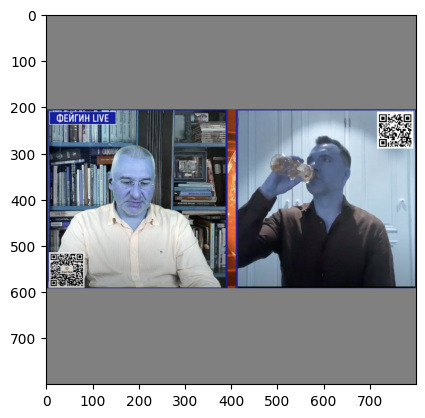

In [76]:
# res = detect("https://cdn.discordapp.com/attachments/1083610420096532581/1116549067036708894/2764483352_A_RAW_photo_of_a_13_year_old_white_girl_blonde_ha_xl-beta-v2-2-2.png")
# res = detect("https://cdn.discordapp.com/attachments/1096822099345145969/1118670993729257603/18c7b730-0548-11ee-84fb-49b3df39f0f4_0.jpeg")
# res = detect("https://image.civitai.com/xG1nkqKTMzGDvpLrqFT7WA/fb2c6c74-97ee-4cda-fda4-8ea23f892200/width=707/8651cacc-5138-4053-e11a-a170817ffd00.jpeg")
res = detect("https://i.imgur.com/NWuGqwl.jpg")
res

In [38]:
res

[]

In [84]:
type(res[0][1])

float

In [55]:
# import sys


# def get_library_path():
#     mod = sys.modules['onnxruntime_extensions._extensions_pydll']
#     return mod.__file__


# def test_inference(onnx_model_file):
#     import onnxruntime as ort
#     import numpy as np

#     providers = ['CPUExecutionProvider']
#     session_options = ort.SessionOptions()
#     # session_options.register_custom_ops_library(get_library_path())

#     image = np.frombuffer(open('/Users/olehkopyl/Downloads/8651cacc-5138-4053-e11a-a170817ffd00.png', 'rb').read(), dtype=np.uint8)
#     session = ort.InferenceSession(str(onnx_model_file), providers=providers)

#     inname = [i.name for i in session.get_inputs()]
#     inp = {inname[0]: image}
#     outputs = session.run(['image_out'], inp)[0]
#     # open('./test/data/result.jpg', 'wb').write(outputs)
#     return outputs

In [ ]:
# test_inference("best.onnx")